# Ecommerce Site Traffic Sales Classification
Carly Tsuda

Flatiron School

Phase 3 Project

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import sklearn

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns

#to print all output from the cell, not just the last line
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc


from imblearn.over_sampling import SMOTE, SMOTENC

#toggle printing visualizations
visualizations = True

In [145]:
df = pd.read_csv('data/online_shoppers_intention.csv')

### Business Problem

This classification project examines a dataset of online shopping sessions to predict whether or not the session ended in a purchase. The imagined audience is a web development firm looking to improve the ecommerce functionalities they offer their clients. They are hoping to develop new ecommerce tools and functionalities for their platform. Development of this classification model is the first exploratory step to understand the needs of their clients. This model might pave the way for development and A/B testing of new ecommerce features.

This firm would like to demonstrate their return on their clients' investment by demonstrating how they might help their clients convert traffic into sales. Those clients might be small(ish) business owners, who are hoping to optimize their advertising strategies, learn what types of customers to target, and drive overall sales.

### Data Understanding

For this project, I used a dataset titled "Online Shoppers Purchasing Intention" from the UCI Machine Learning Repository. The data was used in a 2018 article on machine learning models' potential for predicting user behavior in ecommerce sites, and was donated to the repository in 2018 

After spending some time with the data, I informally organized the 18 features into several categories:

<b> Type of pages visited and session duration </b> <br>
These features include the number of Administrative, Informational, and Product-Related pages visited in the session, and the total duration spent in each of those categories in seconds.

<b> Qualities of pages visited </b> <br>
This section includes Google analytics data for the pages visited in this session, aggregated by mean. Includes Bounce Rates (frequency of sessions that enter and exit on a given page), Exit Rates (frequency of sessions that end on this page), and Page Values (rate at which the given page leads to a purchase) for each page.

<b> Season session occurred </b> <br>
These two features indicate which month the session occurred, and the session's proximity to one of two designated 'Special Day's, or days expected to yield a high number of gift purchases (Valentine's Day and Mother's Day). 

<b> User information </b> <br>
Finally, there was a handful of data about the user collected for each session: the operating system and browser type used to access the site, and the region where the user is located. Additionally, we know how the user came to the site (Traffic Type) and if they had previously visited the site (Visitor Type). Whether the session occurred on a weekend is captured in Weekend.

In [146]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Quick summary statistics:
* 12,330 data points
* 15% sales/85% no sale
* Average number of total pages viewed : 34
* Average time spent on site : 22 minutes
* Average page value: 5.88
* Sales peaks in March/May and November/December

I added the total page views and the total time spent on the site as additional features. I expected that these features would correlate strongly with Producted Related counts and duration, but thought that it was useful to capture how the user interacted with the overall site during their session. 

In [147]:
#create new features by summing existing features
df['Total_Pages'] = df.apply(lambda row: row.Administrative + row.Informational + row.ProductRelated, axis=1)
df['Total_Duration'] = df.apply(lambda row: row.Administrative_Duration + row.Informational_Duration + row.ProductRelated_Duration, axis=1)

#move the new columns to a place in the dataset where I prefer them
cols = df.columns.tolist()
new_cols = cols[:6] + cols[-2:] + cols[6:-2]

df = df[new_cols]
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Total_Pages,Total_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [148]:
#create lists of categorical/continuous features for visualizations and piplining

categorical_feats = df.columns.tolist()[12:-1]
numerical_feats = df.columns.tolist()[:12]

# print(categorical_feats)
# print(numerical_feats)



#### Visualizations

In [149]:
#Month
#some housekeeping to keep the months in order in visualizations

months = ["Feb", "Mar", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df['Month'] = pd.Categorical(df['Month'], categories=months, ordered=True)

fig = go.Figure()
fig.add_trace(go.Histogram(x=df['Month'].loc[df['Revenue'] == 0], 
                           name = 'No Sale',
                          marker_color = '#1A9988',
                          opacity = 0.75))
fig.add_trace(go.Histogram(x=df['Month'].loc[df['Revenue'] == 1], 
                           name = 'Sale',
                          marker_color = '#EB5600',
                          opacity = 0.75))
#keeps the months in order
fig.update_xaxes(categoryorder = 'array', categoryarray=np.array(months))
fig.update_layout(barmode='stack', 
                  hovermode=False, 
                  title = 'Relative Traffic by Month',
                 xaxis_title_text = 'Month',
                 yaxis_title_text = 'Counts')


fig.show()


In [150]:
#Traffic Type
#this needs to happen anyways, moving it up to make the graph nicer
#code snippet below from stackoverflow
series = pd.value_counts(df['TrafficType'])
mask = (series/series.sum() * 100).lt(1)
# To replace df['column'] use np.where I.e 
df['TrafficType'] = np.where(df['TrafficType'].isin(series[mask].index),'Other',df['TrafficType'])

#enforce the order of the columns
tt = ['1', '2', '3', '4', '5', '6', '8', '10', '11', '13', '20', 'Other']
df['TrafficType'] = pd.Categorical(df['TrafficType'], categories=tt, ordered=True)

fig = go.Figure()
fig.add_trace(go.Histogram(x=df['TrafficType'].loc[df['Revenue'] == 0], 
                           name = 'No Sale',
                          marker_color = '#1A9988',
                          opacity = 0.75))
fig.add_trace(go.Histogram(x=df['TrafficType'].loc[df['Revenue'] == 1], 
                           name = 'Sale',
                          marker_color = '#EB5600',
                          opacity = 0.75))
#keeps the months in order
fig.update_xaxes(categoryorder = 'array', 
                 categoryarray=np.array(tt),
                 type = 'category')
fig.update_layout(barmode='stack', 
                  hovermode=False, 
                  title = 'Traffic Type Counts',
                 xaxis_title_text = 'Traffic Type',
                 yaxis_title_text = 'Counts')


fig.show()



In [151]:
# page values

fig = go.Figure()

fig.add_trace(go.Violin(x=df['Revenue'][df['Revenue']==0],
                        y=df['PageValues'][df['Revenue'] == 0],
                        name='No Sale',
                        line_color = '#1A9988',
                        fillcolor='#1A9988',
                        opacity=0.75
             ))
fig.add_trace(go.Violin(x=df['Revenue'][df['Revenue']==1],
                        y=df['PageValues'][df['Revenue'] == 1],
                        name='Sale',
                        line_color = '#EB5600',
                        fillcolor='#EB5600',
                        opacity=0.75
             ))
fig.update_yaxes(range = [-5,100])

fig.update_layout(hovermode=False, 
                  title = 'Average Page Value by Revenue',
                 xaxis_title_text = 'Sale',
                 yaxis_title_text = 'Average Page Value',
                 xaxis=dict(showticklabels=False))
fig.show()

#### Other

I considered the possibility that the site the data represented was new, or had been newly linked to Google Analytics for the purposes of the project. I wanted to see if the Google Analytics features would change over time as more users interacted with the site. After printing out the following visualizations, it seems that the distribution of data over time parallels that of other features plotted against Month. 

In [152]:
    
fig = make_subplots(rows=3, cols=1)

fig.append_trace(go.Scatter(
    x = df["Month"], y=df["BounceRates"],
    name='Bounce Rates',
    mode='markers',
    marker_color = '#22577a'
), row=1, col=1)

fig.append_trace(go.Scatter(
    x = df["Month"], y=df["ExitRates"],
    name='Exit Rates',
    mode='markers',
    marker_color='#38a3a5'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x = df["Month"], y=df["PageValues"],
    name='Page Values',
    mode='markers',
    marker_color='#57cc99'
), row=3, col=1)

fig.update_layout(hovermode=False)
#this line of code took me 45 minutes rip
fig.update_xaxes(categoryorder = 'array', categoryarray=np.array(months))
fig.show()

After reading the scant literature on the conceptualization of the 'Special Day' feature, I wanted to explore it further. Is there a 'Special Day' for each month? Which days are 'Special'? Do they correlate with sales peaks?

My investigation was short, as it turns out there were only two 'Special Days', and they were those named in the study: Valentine's Day and Mother's Day

In [153]:
df.groupby('Month')['SpecialDay'].mean()

Month
Feb     0.233696
Mar     0.000000
May     0.212366
June    0.000000
Jul     0.000000
Aug     0.000000
Sep     0.000000
Oct     0.000000
Nov     0.000000
Dec     0.000000
Name: SpecialDay, dtype: float64

As attentive readers may have noticed, this dataset is missing several months' worth of data! We have no data for January or April. In addition to having incomplete monthly data, this also renders the overall counts from month-to-month suspect, ad we're not sure if certain months are lower count due to lower traffic, or due to errors in data collection. 

### Data Preparation

Several of my categorical variables has categories with counts so low that when the data was split into training and test data, some categories wouldn't appear in the test data. For consistency across the training and test data, I grouped low-count categories into a single 'other' (coded as '99', since the categories were all integers). 

In [154]:
#columns with low-count categories
sm_outliers = ['OperatingSystems', 'Browser']

#this loop codes any low-count category as a single replacement value. I chose 99
for each in sm_outliers:
    #code snippet below from stackoverflow
    series = pd.value_counts(df[each])
    mask = (series/series.sum() * 100).lt(1)
    # To replace df['column'] use np.where I.e 
    df[each] = np.where(df[each].isin(series[mask].index),'Other',df[each])
    
    #print(df[each].value_counts())

In [155]:
#correctly type casting some features
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

Here I did the test-train split, separating out 20% of my data to test my models for overfitting.

In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Revenue', axis=1), 
    df['Revenue'], 
    test_size=0.2, 
    stratify=df['Revenue'],  #stratify on the target variable
    random_state=270
    )

I did have some occasion to use the sklearn Pipeline, so I constructed one below. The Pipeline accepts separate categorical and numerical data for preprocessing, then joins the two in the ColumnTransformer section of the pipe, which will be invoked alongside the given model.

I didn't end up using this Pipeline as much as I anticipated given the above complication with SMOTE.


In [157]:
#Pipe segment for numerical features, scales the data
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
    #no imputer because this dataset has no missing values
])

#pipe segment for categorical features, one-hot-encodes the data
cat_pipe = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

#transformer combines the two
transformer = ColumnTransformer(transformers=[
    ('num', num_pipe, numerical_feats),
    ('cat', cat_pipe, categorical_feats)
])

I found a few functions on [Stack Overflow](https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api/57534118#57534118) to extract the processed column headings from the pipeline.

In [158]:
#StackOverflow Function to extract column names from ColumnTransformer

from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in

def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

#get the column names from the pipeline
processed_cols = pd.DataFrame(get_ct_feature_names(dt_pipe.named_steps['ColumnTransformer']))


Here I used SMOTE to create synthetic data points with a positive target (sales) to balance out the negative values (sessions without a sale). Because the class imbalance in my model was pretty dramatic, SMOTE proved to be a really crucial tool. The difference between balanced and unbalanced data will be apparent in the modeling section.  

In [159]:
#Create list of indices for SMOTE-NC
cat_idx = list(range(12, 19))

#use SMOTE to create synthetic columns so that there are an equal number of positive/negative values
smote = SMOTENC(categorical_features=cat_idx, random_state = 27)

#SMOTE NC requires an array of indicies

X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

#print value counts out to check transformation
# print('Original data:')
# print(y_train.value_counts())

# print('Resampled data:')
# print(y_train_resampled.value_counts())

### Modeling

#### Logistic Regression

I started with a basic logistic regression model using the pipeline that I had constructed. Since it's going through the pipeline, the data will be one-hot-encoded and scaled. Looks like our accuracy score is pretty good for a first model!


In [160]:
lr_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', LogisticRegression(random_state=270, solver='lbfgs', max_iter=250))
])

lr_pipe.fit(X_train, y_train)

#print(lr_pipe.score(X_test, y_test))

y_hat_test = lr_pipe.predict(X_test)
y_hat_train = lr_pipe.predict(X_train)

Unfortunately, it seems the model is pretty good at predicting when sessions won't end in a sale, but not great at predicting the sales. Although there's a decent precision score, the recall value is very low, creating a low f1- score. Looks like the model needs some tuning.

In [161]:
#helps the table designate which label is which
target_names = ['No Sale', 'Sale']

#print out the metrics associated with the model
print('Initial Logistic Regression Model')
print('Training Metrics: ')
print(classification_report(y_train, y_hat_train, target_names=target_names))
print('Testing Metrics: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Initial Logistic Regression Model
Training Metrics: 
              precision    recall  f1-score   support

     No Sale       0.90      0.98      0.94      8338
        Sale       0.76      0.39      0.52      1526

    accuracy                           0.89      9864
   macro avg       0.83      0.68      0.73      9864
weighted avg       0.88      0.89      0.87      9864

Testing Metrics: 
              precision    recall  f1-score   support

     No Sale       0.90      0.97      0.93      2084
        Sale       0.71      0.38      0.50       382

    accuracy                           0.88      2466
   macro avg       0.80      0.68      0.71      2466
weighted avg       0.87      0.88      0.86      2466



Just to mark the starting point, I created confusion matrices for this initial model. As expected, there are more false positives than is acceptable.

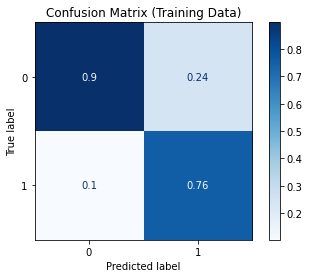

In [162]:
cf_train = confusion_matrix(y_train, y_hat_train)

plot_confusion_matrix(
    lr_pipe,
    X_train,
    y_train,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Confusion Matrix (Training Data)');

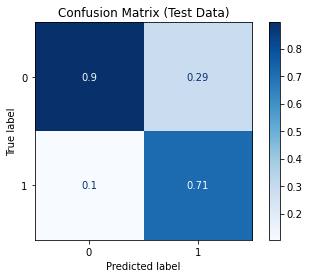

In [163]:
cf_test = confusion_matrix(y_test, y_hat_test)
plot_confusion_matrix(
    lr_pipe,
    X_test,
    y_test,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Confusion Matrix (Test Data)');

After seeing the results of the initial pass, I want to correct the dramatic class imbalance of the dataset. I re-fit the model with and instance of the training data that had been balanced with values generated by SMOTE. 

In [164]:
#fit the pipe with class-balanced data
lr_pipe.fit(X_train_resampled, y_train_resampled)

#make y-Hats
y_hat_train = lr_pipe.predict(X_train_resampled)
y_hat_test = lr_pipe.predict(X_test)

#print out the metrics associated with the model
print('SMOTE Class-Balanced Logistic Regression')
print('Training data metrics:')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Test data metrics:')
print(classification_report(y_test, y_hat_test, target_names=target_names))

SMOTE Class-Balanced Logistic Regression
Training data metrics:
              precision    recall  f1-score   support

     No Sale       0.86      0.89      0.87      8338
        Sale       0.88      0.85      0.87      8338

    accuracy                           0.87     16676
   macro avg       0.87      0.87      0.87     16676
weighted avg       0.87      0.87      0.87     16676

Test data metrics:
              precision    recall  f1-score   support

     No Sale       0.94      0.88      0.91      2084
        Sale       0.51      0.68      0.58       382

    accuracy                           0.85      2466
   macro avg       0.72      0.78      0.74      2466
weighted avg       0.87      0.85      0.86      2466



With the balanced data, we see a significant drop in the precision of the model, but a serious improvement in the recall. This makes sense: the model is making more positive guesses, resulting in a higher rate of false positives, and thus, a lower prevision. Although the overall accuracy of the model is lower, the f1-score has improved quite a bit. The results are inconsistent across the training and test data, indicating that the balanced model is overfit.

The changes in the confusion matrix demonstrate how the balanced training data redistributed the predictions in the test data.

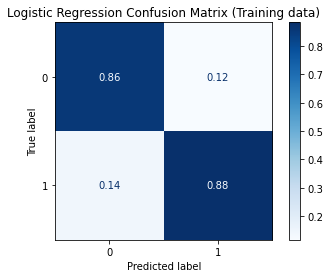

In [165]:
#training confusion matrix, predictions
plot_confusion_matrix(
    lr_pipe,
    X_train_resampled,
    y_train_resampled,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Logistic Regression Confusion Matrix (Training data)');

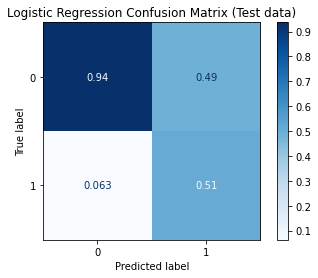

In [166]:
#Test confusion matrix, predictions
plot_confusion_matrix(
    lr_pipe,
    X_test,
    y_test,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Logistic Regression Confusion Matrix (Test data)');

In [167]:
lr_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', LogisticRegression(class_weight = 'balanced', random_state=270, solver='lbfgs', max_iter=250))
])

lr_pipe.fit(X_train, y_train)

#print(lr_pipe.score(X_test, y_test))

y_hat_test = lr_pipe.predict(X_test)
y_hat_train = lr_pipe.predict(X_train)

#print out the metrics associated with the model
print('Class Weight Balanced Logistic Regression')
print('Training data metrics: ')
print(classification_report(y_train, y_hat_train, target_names=target_names))
print('Testing data metrics: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Class Weight Balanced Logistic Regression
Training data metrics: 
              precision    recall  f1-score   support

     No Sale       0.95      0.87      0.91      8338
        Sale       0.52      0.77      0.62      1526

    accuracy                           0.85      9864
   macro avg       0.74      0.82      0.76      9864
weighted avg       0.89      0.85      0.86      9864

Testing data metrics: 
              precision    recall  f1-score   support

     No Sale       0.95      0.86      0.90      2084
        Sale       0.50      0.77      0.61       382

    accuracy                           0.84      2466
   macro avg       0.73      0.82      0.75      2466
weighted avg       0.88      0.84      0.86      2466



The ROC curve is pretty strong, which emphasizes that our recall is much improved after having balanced the training data. 

In [168]:
y_score = lr_pipe.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

Although correcting for the class imbalance improved the data quite a bit, the f-1 score is still not as high as it could be. This is as far as logistic regression can take this data for now; however, the model could be improved by using a different model (like a decision tree or random forest) to generate a list of optimal features we could use to better train the logistic model.

#### Decision Tree

I chose the decision tree for my second model to see what a more rigorous model would make of the data. Given that the logistic model was somewhat underfit, I was interested to see how the decision tree would perform.

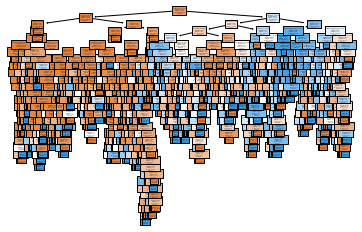

In [169]:
dt_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', tree.DecisionTreeClassifier(criterion='entropy'))
])

dt_pipe.fit(X_train, y_train)

#print(dt_pipe.score(X_test, y_test))

tree.plot_tree(dt_pipe.named_steps['Classifier'],
             feature_names = processed_cols.to_numpy(),
             class_names = np.unique(y_train).astype('str'),
             filled=True);

The decision tree needs pruning. The raw, first-run results definitely showed overfitting, but the training results were not as bad as expected. Without any tuning/pruning, the results were only .03 f1 points lower than the final logistic regression model. 

In [170]:
# make y_hats
y_hat_train = dt_pipe.predict(X_train)
y_hat_test = dt_pipe.predict(X_test)

#print classification reports
print('Initial Decision Tree Metrics')
print('Training data: ')
print(classification_report(y_train, y_hat_train, target_names=target_names))
print('Testing data: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Initial Decision Tree Metrics
Training data: 
              precision    recall  f1-score   support

     No Sale       1.00      1.00      1.00      8338
        Sale       1.00      1.00      1.00      1526

    accuracy                           1.00      9864
   macro avg       1.00      1.00      1.00      9864
weighted avg       1.00      1.00      1.00      9864

Testing data: 
              precision    recall  f1-score   support

     No Sale       0.92      0.92      0.92      2084
        Sale       0.58      0.56      0.57       382

    accuracy                           0.87      2466
   macro avg       0.75      0.74      0.75      2466
weighted avg       0.87      0.87      0.87      2466



Before starting hyper-parameter tuning, ran the model with the resampled version of the data to better understand how that would influence the results.

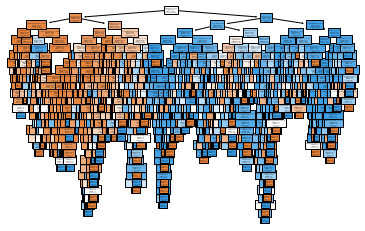

In [171]:
dt_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', tree.DecisionTreeClassifier(criterion='entropy'))
])

dt_pipe.fit(X_train_resampled, y_train_resampled)

#print(dt_pipe.score(X_test, y_test))

tree.plot_tree(dt_pipe.named_steps['Classifier'],
             feature_names = processed_cols.to_numpy(),
             class_names = np.unique(y_train).astype('str'),
             filled=True);

Once again, the results are definitely overfit, but the end results of our test data aren't terrible.

In [172]:
#make y-hats
y_hat_train = dt_pipe.predict(X_train_resampled)
y_hat_test = dt_pipe.predict(X_test)

#print classification reports
print('Decision Tree Metrics')
print('Training data: ')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Testing data: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Decision Tree Metrics
Training data: 
              precision    recall  f1-score   support

     No Sale       1.00      1.00      1.00      8338
        Sale       1.00      1.00      1.00      8338

    accuracy                           1.00     16676
   macro avg       1.00      1.00      1.00     16676
weighted avg       1.00      1.00      1.00     16676

Testing data: 
              precision    recall  f1-score   support

     No Sale       0.94      0.89      0.91      2084
        Sale       0.53      0.69      0.60       382

    accuracy                           0.86      2466
   macro avg       0.73      0.79      0.75      2466
weighted avg       0.88      0.86      0.86      2466



To more efficiently conduct the hyperparameter turning, I implemented a grid search to optimize the best parameters. I tried passing an even greater range of values to my grid search using a goldilocks method, but didn't show all of those iterations in this notebook. Finally, I limited some of the parameters using the basic idea that minimizing 'max-' features and maximizing 'min-' features would help mitigate overfitting.

In [173]:
#recreate the pipeline with no parameters
dt_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', tree.DecisionTreeClassifier())
])

#grid search parameter grid. I made these numbers up
param_grid = {
    'Classifier__criterion' : ['gini', 'entropy'],
    'Classifier__max_depth' : [2, 5, 7, 10, 15],
    'Classifier__min_samples_split' : [2, 3, 4, 5 ],
    'Classifier__max_features': [15, 25, 30, 45],
    'Classifier__max_leaf_nodes' : [10, 15, 20]
}

#implement grid seach with 5 levels of cross-validation
gs_tree = GridSearchCV(dt_pipe, param_grid, cv = 5)
#fit to balanced data
gs_tree.fit(X_train_resampled, y_train_resampled);
#print the best parameters
print(gs_tree.best_params_)

{'Classifier__criterion': 'entropy', 'Classifier__max_depth': 10, 'Classifier__max_features': 45, 'Classifier__max_leaf_nodes': 15, 'Classifier__min_samples_split': 4}


After much hyperparameter tuning, this was the optimum model. It's still overfit, and the results are only marginally better than the logistic regression model. I did like to see a higher precision rate, and the recall and f1 scores did improve. 

In [174]:
#create y_hats
y_hat_train = gs_tree.predict(X_train_resampled)
y_hat_test = gs_tree.predict(X_test)

#print classification reports
print('Decision Tree with Grid Search metrics')
print('Training Data Metrics:')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Testing Data Metrics:')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Decision Tree with Grid Search metrics
Training Data Metrics:
              precision    recall  f1-score   support

     No Sale       0.92      0.88      0.90      8338
        Sale       0.88      0.92      0.90      8338

    accuracy                           0.90     16676
   macro avg       0.90      0.90      0.90     16676
weighted avg       0.90      0.90      0.90     16676

Testing Data Metrics:
              precision    recall  f1-score   support

     No Sale       0.96      0.88      0.92      2084
        Sale       0.56      0.81      0.66       382

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



After Grid Search provided the optimal combination of hyperparameters, I printed out the resulting Decision Tree.

0.8811841038118411


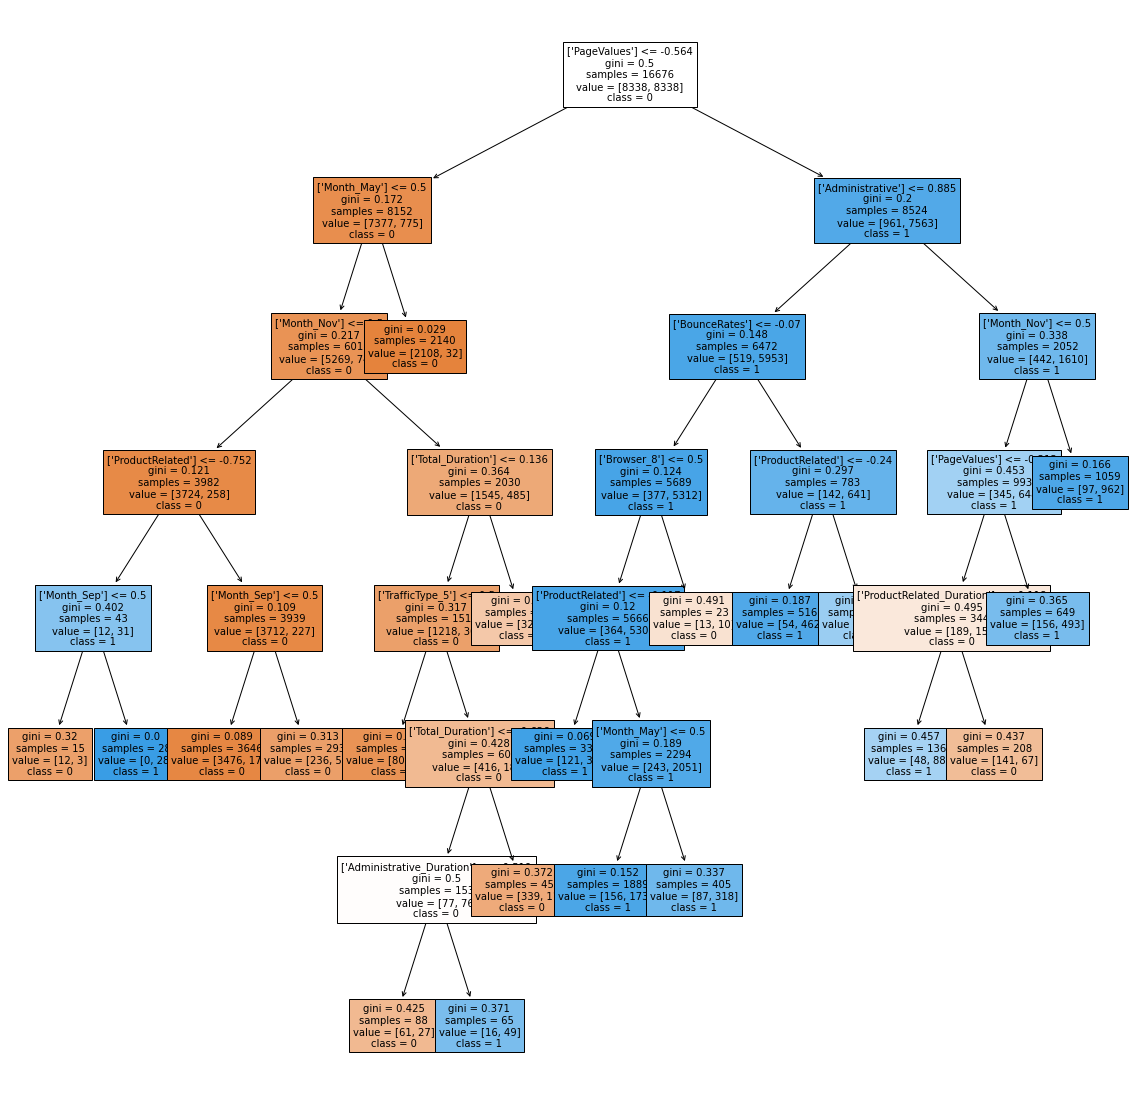

In [175]:
# the grid search got me pretty far, but it had a hard time when I tried to pass it into the
# plot_tree function, so I manually input the best parameters so I could plot the tree.
dt_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', tree.DecisionTreeClassifier(criterion='gini',
                                              max_depth = 10,
                                              max_features = 30,
                                              max_leaf_nodes = 20,
                                              min_samples_split = 4))
])

#fit the model with balanced data 
dt_pipe.fit(X_train_resampled, y_train_resampled)

#print the score
print(dt_pipe.score(X_test, y_test))

#print the tree 
plt.figure(figsize=(20,20))
plt.title('Decision Tree with Grid-Search Optimized Hyperparameters')
tree.plot_tree(dt_pipe.named_steps['Classifier'],
             feature_names = processed_cols.to_numpy(),
             class_names = np.unique(y_train).astype('str'),
             filled=True,
              fontsize=10);

Next, I wanted to extract the features the Decision Tree used and their respective weights. I extracted the processed column headings from the pipeline, then merged the headings with the feature_importances_ data. Our optimal model is almost entirely based on the Page Values data from Google Analytics. While there are other features contributing to the model, Page Values is at 0.90, while the next highest feature is Month_Nov at only 0.02! It seems that our model is riding almost entirely off of a single feature. 

There are also surprising features missing from the above list. Visitor type and Region are both absent from the list.

In [176]:
#print the features and their weights
#get the feature weights from the model
important_feats = pd.DataFrame(dt_pipe.named_steps['Classifier'].feature_importances_)
#get the column names from the pipeline
#processed_cols = pd.DataFrame(get_ct_feature_names(dt_pipe.named_steps['ColumnTransformer']))
#combine the columns
feature_weights = pd.concat([processed_cols, important_feats], axis=1)
#name them
feature_weights.columns = ['FeatureName', 'Weight']
#remove ones that aren't used
feature_weights.loc[feature_weights['Weight'] > 0]

,FeatureName,Weight
0,Administrative,0.009920
1,Administrative_Duration,0.002602
4,ProductRelated,0.011951
5,ProductRelated_Duration,0.003024
7,Total_Duration,0.006060
8,BounceRates,0.003175
10,PageValues,0.918218
17,Month_May,0.008517
18,Month_Nov,0.025880
20,Month_Sep,0.004244


Since I've landed on my final model, I'll take a look at the confusion matrices.

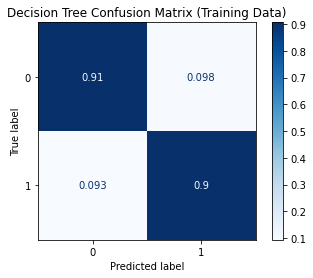

In [177]:
#training confusion matrix, normalized on predictions
plot_confusion_matrix(
    dt_pipe,
    X_train_resampled,
    y_train_resampled,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Decision Tree Confusion Matrix (Training Data)');

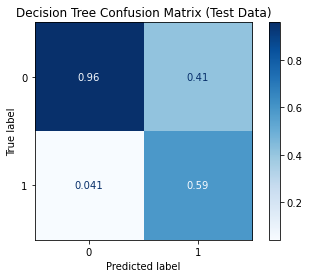

In [178]:
#test confusion matrix, normalized on predictions
plot_confusion_matrix(
    dt_pipe,
    X_test,
    y_test,
    cmap='Blues',
    normalize = 'pred'
    )
plt.grid(False)
plt.title('Decision Tree Confusion Matrix (Test Data)');

The overfitting is particularly apparent when comparing the training and testing confusion matrices. There's a pretty significant difference in performance.

And finally, I'll create an ROC curve and print the AUC. 

In [179]:
#calculate roc/auc data
y_score = lr_pipe.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

#Code borrowed from plotly documentation
#plot ROC curve 
fig = px.area(
    x=fpr, y=tpr,
    title=f'Decision Tree ROC Curve (AUC={auc(fpr, tpr):.4f})', #include AUC in the title
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

#add 1=1 line
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#### Random Forest

After tuning the decision tree, I still thought that we could have an even better model. To try to get a more precise model with better recall while mitigating the existing issue of overfitting, I chose a random forest. I started with a relatively low numbers of estimators, and a max depth of 5 to attempt to avoid overfitting.

In [180]:
#new end to the pipe for the random forest
forest_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=27))
])

#fit the model with basic data
forest_pipe.fit(X_train, y_train);

#create y_hats
y_hat_train = forest_pipe.predict(X_train)
y_hat_test = forest_pipe.predict(X_test)

#print classification reports
print('First Random Forest Metrics')
print('Training Data Metrics: ')
print(classification_report(y_train, y_hat_train, target_names=target_names))
print('Test Data Metrics: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

First Random Forest Metrics
Training Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.87      1.00      0.93      8338
        Sale       0.95      0.20      0.33      1526

    accuracy                           0.87      9864
   macro avg       0.91      0.60      0.63      9864
weighted avg       0.88      0.87      0.84      9864

Test Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.86      1.00      0.93      2084
        Sale       0.89      0.15      0.25       382

    accuracy                           0.86      2466
   macro avg       0.88      0.57      0.59      2466
weighted avg       0.87      0.86      0.82      2466



Without balanced data, our random tree did no better than the other models. 

In [181]:
#refit with balanced data
forest_pipe.fit(X_train_resampled, y_train_resampled)

#create y_hats
y_hat_train = forest_pipe.predict(X_train_resampled)
y_hat_test = forest_pipe.predict(X_test)

#print classification reports
print('Random Forest Metrics, Class Balanced')
print('Training Data Metrics: ')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Test Data Metrics: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Random Forest Metrics, Class Balanced
Training Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.92      0.88      0.90      8338
        Sale       0.89      0.92      0.90      8338

    accuracy                           0.90     16676
   macro avg       0.90      0.90      0.90     16676
weighted avg       0.90      0.90      0.90     16676

Test Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.96      0.89      0.92      2084
        Sale       0.56      0.80      0.66       382

    accuracy                           0.87      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.87      0.88      2466



Ultimately, this is about as good as out random forest is going to get, even after hyperparameter tuning. However, I didn't know that at the time! So I went ahead and implemented a grid search. Given that random forests have a higher computation time, I limited the number of parameters.

In [182]:
#new classifier pipe section for the grid search
forest_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', RandomForestClassifier(random_state = 27))
])

#parameter grid for the gridsearch object (I made these numbers up)
param_grid = {
    'Classifier__criterion' : ['gini', 'entropy'],
    'Classifier__max_depth' : [2, 5],
    'Classifier__min_samples_split' : [2, 3, 4, 5],
    'Classifier__max_features': [10, 15, 25],
    'Classifier__max_leaf_nodes' : [10, 15]
}

#create Grid Search Object
gs_forest = GridSearchCV(forest_pipe, param_grid, cv = 3);

#fit the best model
gs_forest.fit(X_train_resampled, y_train_resampled)

#print best parameters
print('Best parameters from Grid Search: ')
print(gs_forest.best_params_)

Best parameters from Grid Search: 
{'Classifier__criterion': 'gini', 'Classifier__max_depth': 5, 'Classifier__max_features': 25, 'Classifier__max_leaf_nodes': 15, 'Classifier__min_samples_split': 2}


In [183]:
#get y hats
y_hat_train = gs_forest.predict(X_train_resampled)
y_hat_test = gs_forest.predict(X_test)

#print classification reports
print('Random forest with Grid Search')
print('Training Data Metrics: ')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Test Data Metrics: ')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Random forest with Grid Search
Training Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.91      0.89      0.90      8338
        Sale       0.89      0.91      0.90      8338

    accuracy                           0.90     16676
   macro avg       0.90      0.90      0.90     16676
weighted avg       0.90      0.90      0.90     16676

Test Data Metrics: 
              precision    recall  f1-score   support

     No Sale       0.96      0.89      0.93      2084
        Sale       0.58      0.79      0.67       382

    accuracy                           0.88      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.90      0.88      0.89      2466



As a last attempt to find better numbers, I created a random search grid with a greater number of parameters to try to see if it would produce anything different from the previous models. 

In [184]:
#new classifier pipe segment
forest_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', RandomForestClassifier(random_state=27))
])

#new grid for random search
param_grid = {
    'Classifier__bootstrap' : [True, False],
    'Classifier__criterion' : ['gini', 'entropy'],
    'Classifier__max_depth' : [10, 20, 30, 40],
    'Classifier__min_samples_leaf' : [1, 2, 4],
    'Classifier__min_samples_split' : [2, 5, 10],
    'Classifier__max_features': ['auto', 'sqrt'],
    'Classifier__max_leaf_nodes' : [10, 15],
    'Classifier__n_estimators': [100, 200, 400]
}

#create random search object
rs_forest = RandomizedSearchCV(forest_pipe, param_grid, cv = 3);
#fit the model
rs_forest.fit(X_train_resampled, y_train_resampled)
#print the best parameters
print('Best parameters from Random Search:')
print(rs_forest.best_params_)

Best parameters from Random Search:
{'Classifier__n_estimators': 100, 'Classifier__min_samples_split': 2, 'Classifier__min_samples_leaf': 4, 'Classifier__max_leaf_nodes': 15, 'Classifier__max_features': 'auto', 'Classifier__max_depth': 30, 'Classifier__criterion': 'entropy', 'Classifier__bootstrap': False}


It didn't. 

In [185]:
#make y_hats
y_hat_train = rs_forest.predict(X_train_resampled)
y_hat_test = rs_forest.predict(X_test)

print('Random forest with Random search results (class balanced):')
print('Training data:')
print(classification_report(y_train_resampled, y_hat_train, target_names=target_names))
print('Test data:')
print(classification_report(y_test, y_hat_test, target_names=target_names))

Random forest with Random search results (class balanced):
Training data:
              precision    recall  f1-score   support

     No Sale       0.91      0.89      0.90      8338
        Sale       0.89      0.91      0.90      8338

    accuracy                           0.90     16676
   macro avg       0.90      0.90      0.90     16676
weighted avg       0.90      0.90      0.90     16676

Test data:
              precision    recall  f1-score   support

     No Sale       0.96      0.89      0.93      2084
        Sale       0.58      0.79      0.67       382

    accuracy                           0.88      2466
   macro avg       0.77      0.84      0.80      2466
weighted avg       0.90      0.88      0.89      2466



In [186]:
#new final pipeline segment with hyperparameters from the Random Search Results
forest_pipe = Pipeline(steps=[
    ('ColumnTransformer', transformer),
    ('Classifier', RandomForestClassifier(n_estimators=200,
                                         min_samples_split=2,
                                         min_samples_leaf=4,
                                         max_leaf_nodes=15,
                                         max_features='sqrt',
                                         max_depth=40,
                                         criterion='entropy',
                                         bootstrap='True'
                                         ))
])

#fit the model
forest_pipe.fit(X_train_resampled, y_train_resampled);

#print(forest_pipe.score(X_test, y_test))

I was interested to see the list of parameters that my forest was using. Given that there are so many more models, each using a different combination of features, I thought that I might see a few more important features pop out. Although these models do use a different spread of features, 'Page Values' remained the core feature.

In [187]:
#get the optimized features from the pipeline
important_feats = pd.DataFrame(forest_pipe.named_steps['Classifier'].feature_importances_)
#get the processed column names from the pipeline
#processed_cols = pd.DataFrame(get_ct_feature_names(dt_pipe.named_steps['ColumnTransformer']))
#combine the dataframes
processed_cols = pd.concat([processed_cols, important_feats], axis=1)
#name the columns
processed_cols.columns = ['FeatureName', 'Weight']
#remove entries with no weight
processed_cols.loc[processed_cols['Weight'] > 0]

,FeatureName,Weight
0,Administrative,0.015422
1,Administrative_Duration,0.056944
2,Informational,0.003158
3,Informational_Duration,0.004841
4,ProductRelated,0.029962
5,ProductRelated_Duration,0.038162
6,Total_Pages,0.014789
7,Total_Duration,0.040252
8,BounceRates,0.032319
9,ExitRates,0.067541


And, once again, our confusion matrices and ROC curve

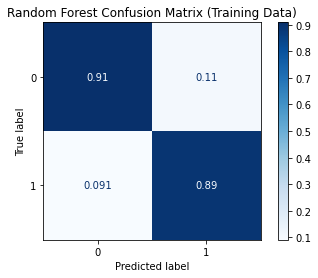

In [188]:
#plot confusion matrix using predictions
plot_confusion_matrix(
    forest_pipe,
    X_train_resampled,
    y_train_resampled,
    cmap='Blues',
    normalize = 'pred'
    )
plt.title('Random Forest Confusion Matrix (Training Data)')
plt.grid(False)

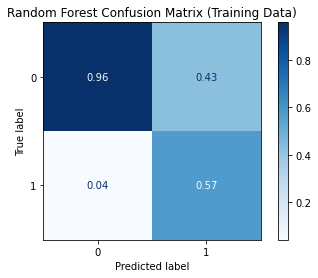

In [189]:
#plot confusion matrix using predictions
plot_confusion_matrix(
    forest_pipe,
    X_test,
    y_test,
    cmap='Blues',
    normalize = 'pred'
    )
plt.title('Random Forest Confusion Matrix (Training Data)')
plt.grid(False)

In [190]:
#fit the ROC curve
y_score = lr_pipe.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

#plot figure (code borrowed from plotly's documentation)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#### Evaluating

Ultimately, each of the models was fairly similar. Although the logistic regression model has slightly lower performance, it is most consistent between the testing and training data. The Decision Tree and Random Forest both overfit, despite my attempts to mitigate overfitting, but yielded decent metrics from the test data.

Model | Accuracy (Train) | Accuracy (Test) | Precision (Train) | Precision (Test) | Recall (Train) | Recall (Test) | f1 (Train)| f1 (Test) | AUC | 
-|-|-|-|-|-|-|-|-|-
Logistic Regression | 0.85 | <b> 0.84 </b> | 0.52 | <b> 0.50 </b> | 0.77 | <b> 0.77 </b> | 0.62 | <b> 0.61 </b> | 0.91
Decision Tree | 0.90 | <b> 0.89 </b> | 0.91 | <b> 0.61 </b> | 0.88 | <b> 0.76 </b> | 0.90 | <b> 0.67 </b> | 0.90
Random Forest | 0.90 |<b>  0.88 </b> | 0.89 | <b> 0.58 </b> | 0.91 | <b> 0.79 </b> | 0.90 | <b> 0.67 </b> | 0.90

As I was hyperparameter tuning the grid search parameters for the Decision Tree and Random Forest models, it became clear that each model was converging at similar values. When I looked at the best features and the corresponding weights, and noticed that both the Decision Tree and Random Forest were almost entirely based around the Page Values feature. This led me to conclude that I had reached the limits of the usefulness of my dataset. It's pretty good at predicting when an ecommerce site session will end in a sale.

### Conclusion

#### Key takeaways
Although the classifying models perform passably well, it was disappointing to see that they primarily used a single variable (Page Values). Because of this, each of the models did pretty well off the bat, only benefited slightly from tuning, and reached peak performance fairly quickly. 

Ultimately, I would say that our model performs fairly well, with Page Values as the primary feature, and Month, Traffic Type, and Total Page count and duration as somewhat significant.

#### Business conclusions
Ultimately, the data demonstrates that some basic insights into the breakdown of where the traffic (and, usually, sales) is coming from can yield fairly powerful results. Some of these insights are things business owners are likely already plugged in to, such as their peak season and key regions. (It's possible that they may also be driving these peaks with targeted ad campaigns.) The key to creating a successful product will be in identifying the less-obvious metrics, such which pages have highest value and where their traffic is coming from, and selling a product to help those business owners leverage that data.

My recommendations would include:
* Develop multiple templates of product pages and do A/B testing to determine which ones generate higher page values
* Incorporate Google Analytics into the sales dashboard for site owners and/or develop an in-house system of complementary site metrics (potentially offered at a 'Premium' tier)
* Encourage site owners to direct advertising resources to high-value, low-bounce pages (perhaps with the help of an AI?), optimized for traffic type
* Offer a percentage subscription model for seasonal businesses (instead of monthly)

#### Limitations and future research

The dataset had quite a few flaws, as I've mentioned above. The missing months give us an incomplete picture of the year, and render the remaining data suspect. Although the researchers took the time to conceptualize a 'Special Day' feature, they only collected the data for two holidays. 

This study also captured a single type of ecommerce site. It would be interesting to repeat the study on sites with subscription services (analyzing churn) or sites that offer products at different price points. More interesting data could be captured from users: Are they subscribed to the newsletter? Do they have an account? Did they use a third-party payment processor like Amazon, Apple, or Paypal? This project could also be repeated as a linear regression with dollar amounts of the sale as the target value.

In [199]:
#Extra visual for non-technical
true_preds = [301, 1864]
false_preds = [81, 220]
labels = ['Sale', 'Not Sale']

fig = go.Figure()
fig.add_trace(go.Bar(x=labels,
                           y=false_preds,
                          marker_color = '#EB5600',
                            name = 'False Predictions',
                          opacity = 0.75))
fig.add_trace(go.Bar(x=labels,
                     y=true_preds,
                     name = 'True Predictions',
                    marker_color = '#1A9988',  
                    opacity = 0.75))

#keeps the months in order
#fig.update_xaxes(categoryorder = 'array', categoryarray=np.array(months))
fig.update_layout(barmode='stack', 
                  hovermode=False, 
                  title = 'Classifier Prediction Success Rates',
                 xaxis_title_text = 'Sales',
                 yaxis_title_text = 'Predictions')


fig.show()